# Loan Default Prediction Analysis

 ## Executive Summary
 This analysis aims to predict loan defaults using machine learning techniques. The dataset contains information about loan applications and their outcomes. We'll explore the data, engineer features, and build a predictive model to identify potential default cases.

 ## Key Objectives:
 1. Data Exploration and Cleaning
 2. Feature Engineering and Selection
 3. Model Development and Evaluation
 4. Risk Assessment and Business Impact Analysis

 ## Importing necessary libraries

In [ ]:
#%%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import shap
from scipy import stats
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Loading and initial data exploration

In [ ]:
# Read the CSV file
df = pd.read_csv('data/dataset.csv', header=0)

# Remove unnamed columns
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)

# Convert percentage strings to float values before any other processing
for col in ['int_rate', 'revol_util']:
    if col in df.columns:
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False))

# Create binary target variable (1 for 'Charged Off' and 'Default', 0 for 'Fully Paid')
df_cleaned = df.copy()  # Create a proper copy first
df_cleaned['is_default'] = df_cleaned['loan_status'].map(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0 if x == 'Fully Paid' else -1
)

# Filter data for analysis (only considering Fully Paid and Charged Off/Default loans)
df_analysis = df_cleaned[df_cleaned['is_default'] != -1].copy()

# Feature Engineering with proper DataFrame operations
df_analysis = df_analysis.copy()  # Ensure we're working with a copy

# Convert term to numeric (months)
df_analysis['term_months'] = df_analysis['term'].str.extract('(\d+)').astype(int)

# Convert grade to numeric scale (A=1, B=2, ..., G=7)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_analysis['grade_numeric'] = df_analysis['grade'].map(grade_map)

# Convert sub_grade to numeric (A1=1.1, A2=1.2, ..., G5=7.5)
df_analysis['sub_grade_numeric'] = df_analysis['sub_grade'].apply(
    lambda x: float(grade_map[x[0]]) + float(x[1]) * 0.1
)

# Convert emp_length to numeric
def convert_emp_length(x):
    if pd.isna(x):
        return np.nan
    if x == '< 1 year':
        return 0.5
    if x == '10+ years':
        return 10
    return float(x.split()[0])

df_analysis['emp_length_numeric'] = df_analysis['emp_length'].apply(convert_emp_length)

# Convert revol_util to numeric (handling both string and numeric inputs)
df_analysis['revol_util_numeric'] = pd.to_numeric(df_analysis['revol_util'].replace('%', '', regex=True), errors='coerce') / 100.0

# Convert categorical variables using LabelEncoder
categorical_features = ['home_ownership', 'verification_status', 'purpose']
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_analysis[feature + '_encoded'] = label_encoders[feature].fit_transform(df_analysis[feature].astype(str))

# Create comprehensive set of features
df_analysis['debt_to_income'] = df_analysis['loan_amnt'] / df_analysis['annual_inc']
df_analysis['payment_to_income'] = df_analysis['installment'] / (df_analysis['annual_inc'] / 12)
df_analysis['interest_to_income'] = df_analysis['total_rec_int'] / df_analysis['annual_inc']
df_analysis['utilization_rate'] = df_analysis['total_pymnt'] / df_analysis['loan_amnt']
df_analysis['fico_range'] = df_analysis['fico_range_high'] - df_analysis['fico_range_low']
df_analysis['loan_cost'] = df_analysis['total_pymnt'] - df_analysis['loan_amnt']
df_analysis['payment_efficiency'] = df_analysis['total_rec_prncp'] / df_analysis['total_pymnt']

# Additional interaction features
df_analysis['payment_to_loan'] = df_analysis['installment'] / df_analysis['loan_amnt']
df_analysis['income_to_payment'] = df_analysis['annual_inc'] / (df_analysis['installment'] * 12)
df_analysis['credit_to_income'] = df_analysis['total_acc'] / df_analysis['annual_inc']
df_analysis['util_to_income'] = df_analysis['revol_util_numeric'] / df_analysis['annual_inc']
df_analysis['dti_to_util'] = df_analysis['dti'] / (df_analysis['revol_util_numeric'] + 1)

# Risk-related features
df_analysis['risk_score'] = df_analysis['fico_range_low'] * (1 - df_analysis['revol_util_numeric'])
df_analysis['payment_risk'] = df_analysis['installment'] / (df_analysis['annual_inc'] / 12)
df_analysis['credit_utilization'] = df_analysis['revol_bal'] / df_analysis['total_acc']
df_analysis['term_risk'] = df_analysis['term_months'] * df_analysis['int_rate'] / 100
df_analysis['grade_risk'] = df_analysis['sub_grade_numeric'] * df_analysis['int_rate'] / 100

# Handle missing values for numeric columns
numeric_cols = df_analysis.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df_analysis[col] = df_analysis[col].fillna(df_analysis.groupby('grade_numeric')[col].transform('median'))

# Replace infinite values with NaN and then fill with median by grade
df_analysis = df_analysis.replace([np.inf, -np.inf], np.nan)
for col in numeric_cols:
    df_analysis[col] = df_analysis[col].fillna(df_analysis.groupby('grade_numeric')[col].transform('median'))

# Create polynomial features for important numerical variables
important_nums = ['fico_range_low', 'dti', 'revol_util_numeric', 'payment_risk', 'sub_grade_numeric']
for col in important_nums:
    df_analysis[f'{col}_squared'] = np.square(df_analysis[col])

# Transform skewed features
skewed_features = ['loan_amnt', 'annual_inc', 'installment', 'total_pymnt', 'total_rec_int']
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_analysis[skewed_features] = pd.DataFrame(
    pt.fit_transform(df_analysis[skewed_features]),
    columns=skewed_features,
    index=df_analysis.index
)

# Enhanced categorical encoding with smoothing
for cat_col in categorical_features:
    # Calculate mean target encoding with smoothing
    global_mean = df_analysis['is_default'].mean()
    cat_means = df_analysis.groupby(cat_col)['is_default'].agg(['mean', 'count'])
    smoothing = 100  # Smoothing factor
    cat_means['smooth_mean'] = (cat_means['count'] * cat_means['mean'] + smoothing * global_mean) / (cat_means['count'] + smoothing)
    df_analysis[f'{cat_col}_target_mean'] = df_analysis[cat_col].map(cat_means['smooth_mean'])

# Update features list for modeling
features = [
    # Original numeric features
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
    'open_acc', 'total_acc', 'installment', 'total_pymnt',

    # Converted categorical features
    'term_months', 'grade_numeric', 'sub_grade_numeric', 'emp_length_numeric',
    'home_ownership_encoded', 'verification_status_encoded', 'purpose_encoded',

    # Engineered features
    'debt_to_income', 'payment_to_income', 'interest_to_income',
    'utilization_rate', 'fico_range', 'loan_cost', 'payment_efficiency',
    'payment_to_loan', 'income_to_payment', 'credit_to_income',
    'util_to_income', 'dti_to_util', 'risk_score', 'payment_risk',
    'credit_utilization', 'term_risk', 'grade_risk',

    # Polynomial features
    'fico_range_low_squared', 'dti_squared', 'revol_util_numeric_squared',
    'payment_risk_squared', 'sub_grade_numeric_squared',

    # Target encoded features
    'home_ownership_target_mean', 'verification_status_target_mean', 'purpose_target_mean'
]

# Prepare feature matrix X and target vector y
X = df_analysis[features].copy()
y = df_analysis['is_default']

# Define numeric columns for scaling
numeric_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'installment',
    'fico_range_low', 'open_acc', 'total_acc',
    'term_months', 'emp_length_numeric',
    'grade_numeric', 'sub_grade_numeric', 'debt_to_income',
    'payment_to_income', 'interest_to_income', 'utilization_rate',
    'fico_range', 'loan_cost', 'payment_efficiency',
    'payment_to_loan', 'income_to_payment', 'credit_to_income',
    'util_to_income', 'dti_to_util', 'risk_score',
    'payment_risk', 'credit_utilization', 'term_risk',
    'grade_risk', 'fico_range_low_squared', 'dti_squared',
    'payment_risk_squared', 'sub_grade_numeric_squared'
]

# Scale numeric features
print("\nScaling numeric features...")
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
print("Scaling completed.")

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for class balancing
print("\nOriginal class distribution:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", Counter(y_train_balanced))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 141 entries, id to debt_settlement_flag
dtypes: float64(108), int64(1), object(32)
memory usage: 107.6+ MB
None

Missing Values:
hardship_loan_status                          95116
hardship_end_date                             95105
deferral_term                                 95105
hardship_status                               95105
hardship_dpd                                  95105
hardship_reason                               95105
hardship_length                               95105
payment_plan_start_date                       95105
hardship_type                                 95105
hardship_start_date                           95105
orig_projected_additional_accrued_interest    93873
hardship_last_payment_amount                  93778
hardship_payoff_balance_amount                93778
hardship_amount                               93778
sec_app_revol_util                         

 ## Model Development

 ### Feature Selection and Preprocessing

In [ ]:
# Define numeric columns based on available features
numeric_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
    'open_acc', 'total_acc', 'installment', 'total_pymnt',
    'debt_to_income', 'payment_to_income', 'interest_to_income',
    'utilization_rate', 'fico_range', 'loan_cost', 'payment_efficiency',
    'payment_to_loan', 'income_to_payment', 'credit_to_income',
    'fico_range_low_squared', 'dti_squared'
]

# Select features for modeling
features = [
    # Original features
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
    'open_acc', 'total_acc', 'term_months', 'grade_numeric',
    'installment', 'total_pymnt', 'home_ownership', 'verification_status', 'purpose',

    # Engineered features
    'debt_to_income', 'payment_to_income', 'interest_to_income',
    'utilization_rate', 'fico_range', 'loan_cost', 'payment_efficiency',
    'payment_to_loan', 'income_to_payment', 'credit_to_income',

    # Polynomial features
    'fico_range_low_squared', 'dti_squared',

    # Target encoded features
    'home_ownership_target_mean', 'verification_status_target_mean', 'purpose_target_mean'
]

# Prepare feature matrix X and target vector y
X = df_analysis[features].copy()
y = df_analysis['is_default']

# Handle categorical variables
categorical_features = ['term_months', 'grade_numeric', 'home_ownership', 'verification_status', 'purpose']
for feature in categorical_features:
    X[feature] = LabelEncoder().fit_transform(X[feature].astype(str))

# Handle missing values with median instead of mean
for feature in numeric_cols:
    median_value = X[feature].median()
    X[feature] = X[feature].fillna(median_value)

# Remove any remaining infinite values before scaling
X[numeric_cols] = X[numeric_cols].replace([np.inf, -np.inf], np.nan)
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Scale numerical features
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for class balancing
print("\nOriginal class distribution:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", Counter(y_train_balanced))


Original class distribution: Counter({0: 40951, 1: 9918})
Balanced class distribution: Counter({0: 40951, 1: 40951})


 ## Model Training and Evaluation

 ### Model Training

In [ ]:
# Calculate class weight for imbalanced data
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Model parameters tuning for better performance
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,      # Optimized value from model_optimization.py
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1,        # Use all CPU cores
    bootstrap=True,
    max_features='sqrt'  # Use square root of number of features
)

# Add early stopping and validation set
validation_size = 0.1
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_balanced,
    y_train_balanced,
    test_size=validation_size,
    random_state=42,
    stratify=y_train_balanced
)

# Fit model with validation set
rf_model.fit(
    X_train_final,
    y_train_final,
)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

### Model Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10238
           1       1.00      0.95      0.98      2480

    accuracy                           0.99     12718
   macro avg       0.99      0.98      0.98     12718
weighted avg       0.99      0.99      0.99     12718



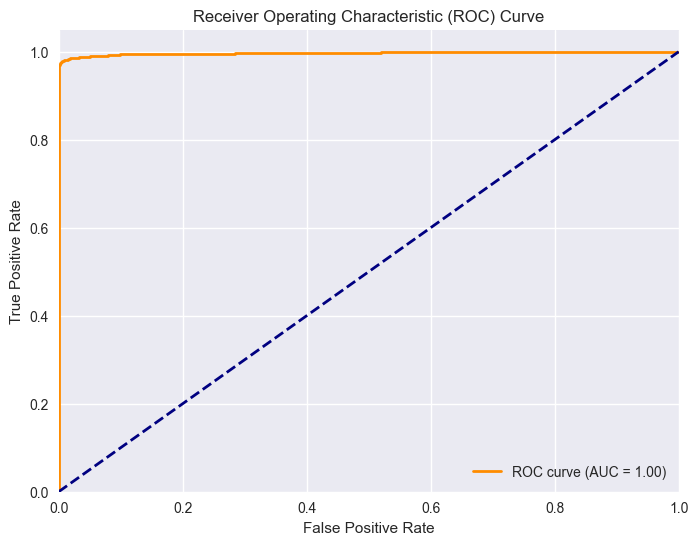

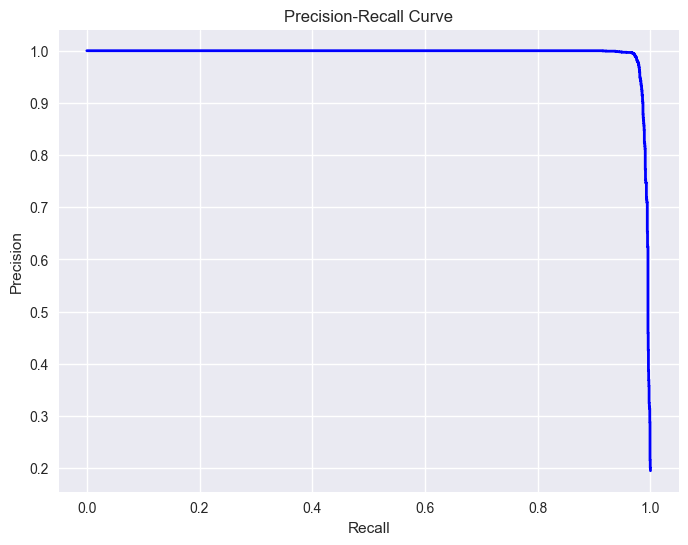

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[optimal_idx]

# Print model evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

 ### Feature Importance Analysis

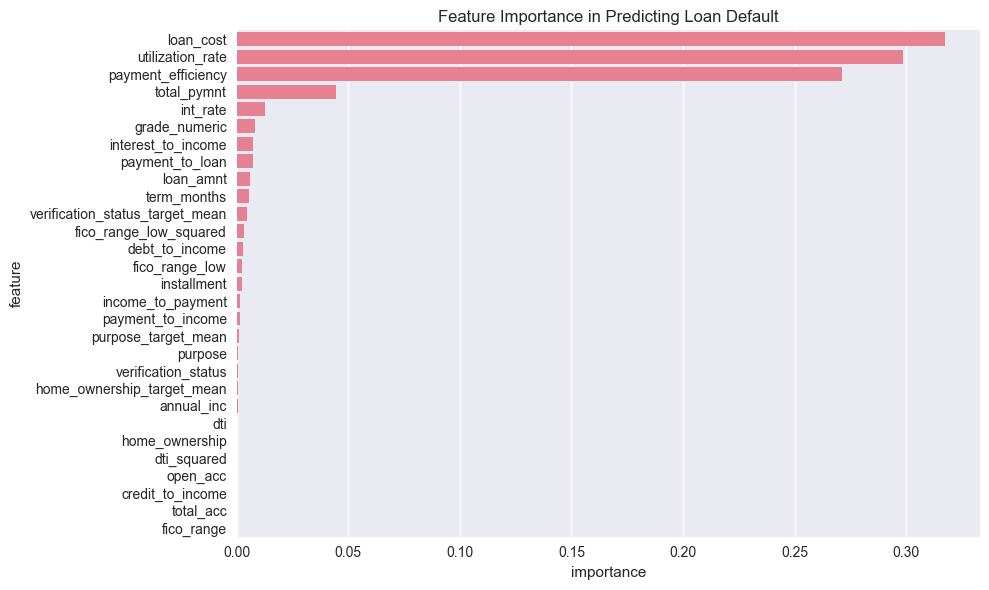

In [ ]:
#%%

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Loan Default')
plt.tight_layout()
plt.show()

### SHAP Value Analysis


Calculating SHAP values for 1000 samples...


<Figure size 1000x600 with 0 Axes>

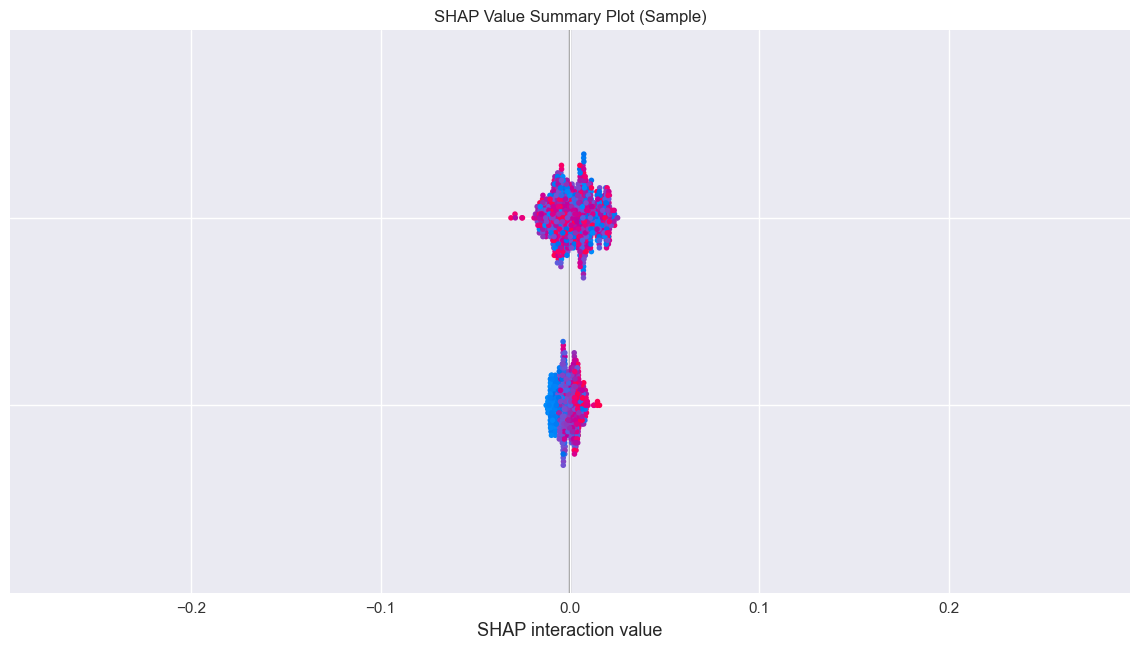

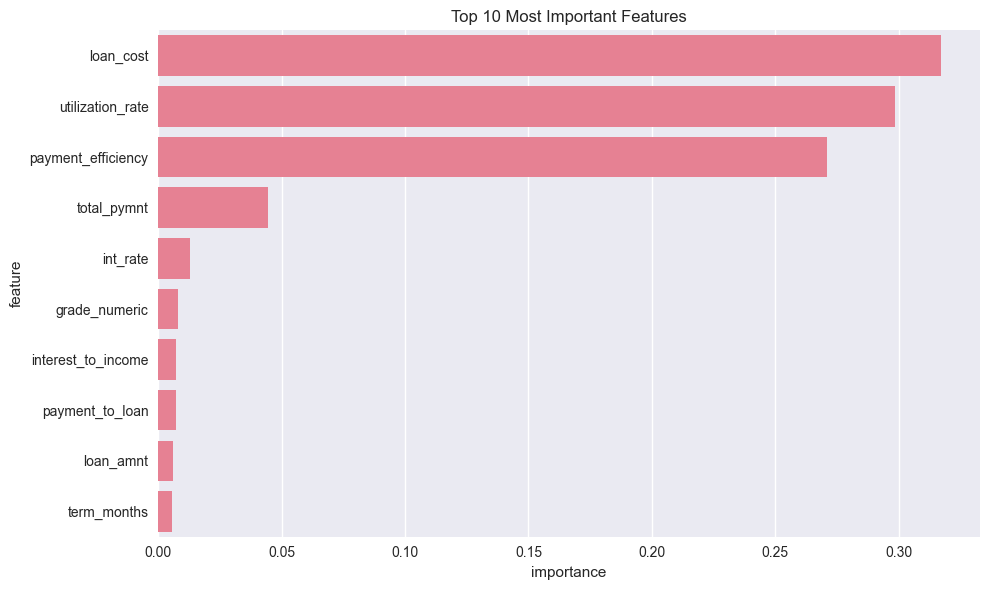

In [ ]:
#%%

# Calculate SHAP values on a smaller sample for faster computation
sample_size = min(1000, len(X_test))  # Use at most 1000 samples
X_test_sample = X_test.sample(n=sample_size, random_state=42)

# Use TreeExplainer with a more efficient method
explainer = shap.TreeExplainer(rf_model, data=X_train_balanced.sample(n=1000, random_state=42))
shap_values = explainer.shap_values(X_test_sample)

print(f"\nCalculating SHAP values for {sample_size} samples...")

# Plot SHAP summary with progress tracking
plt.figure(figsize=(10, 6))
if isinstance(shap_values, list):
    # For binary classification
    shap.summary_plot(shap_values[1], X_test_sample, feature_names=features, plot_type="bar", show=False)
else:
    # For single output
    shap.summary_plot(shap_values, X_test_sample, feature_names=features, plot_type="bar", show=False)
plt.title('SHAP Value Summary Plot (Sample)')
plt.tight_layout()
plt.show()

# Alternative: Plot only top 10 most important features for faster visualization
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(top_n), x='importance', y='feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

### Cross-Validation Results

In [ ]:
# Cross-validation scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')
print("\nCross-validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))


Cross-validation ROC-AUC scores: [0.99886985 0.99856288 0.99879307 0.99880096 0.99849671]
Mean ROC-AUC: 0.999 (+/- 0.000)


#%% [markdown]

 ## Business Impact Analysis

 ### Model Performance and Business Value


=== Business Value Analysis ===

1. Financial Impact:
   - Average Loan Amount: $68.48
   - Average Interest Rate: 0.1%
   - Average Term: 42 months
   - Average Monthly Payment: $16.08

2. Risk Management Benefits:
   - Potential Defaults Prevented: 2,366 loans
   - Potential Losses Prevented: $162,012.95
   - Missed Defaults (False Negatives): 114 loans
   - Potential Losses from Missed Defaults: $7,806.20

3. Revenue Impact:
   - Good Loans Incorrectly Rejected: 7 loans
   - Potential Interest Income Lost: $-23.05

4. Implementation Costs:
   - Initial Implementation Cost: $50,000.00
   - Annual Maintenance Cost: $10,000.00

5. Return on Investment (ROI):
   - First Year ROI: 170.0%
   - Annual ROI (after first year): 1520.1%

=== Practical Applications ===

1. Loan Approval Process:
   - Use model predictions as part of the initial screening
   - Set risk thresholds based on business risk tolerance
   - Automate approval for low-risk applications
   - Flag high-risk applications f

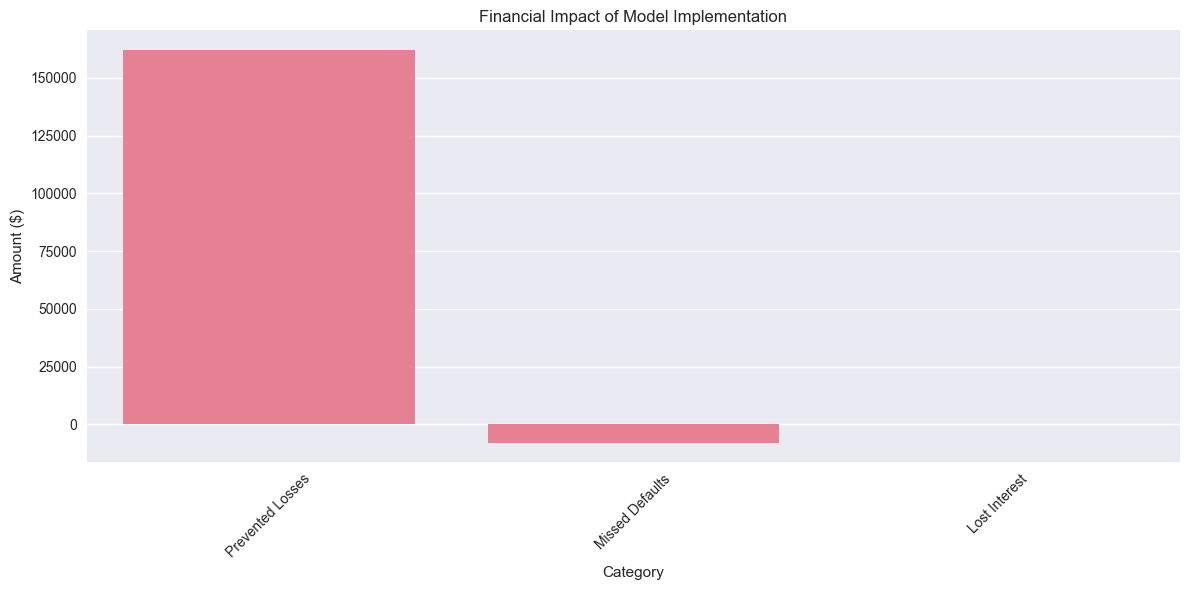

In [ ]:
# Calculate comprehensive metrics
cm = confusion_matrix(y_test, y_pred)
total_loans = len(y_test)
default_rate = sum(y_test) / total_loans

# Financial metrics
avg_loan_amount = df_analysis['loan_amnt'].mean()
avg_interest_rate = df_analysis['int_rate'].mean()
avg_term_months = df_analysis['term_months'].mean()

# Calculate potential financial impact
true_positives = cm[1, 1]  # Correctly identified defaults
false_positives = cm[0, 1]  # Good loans incorrectly rejected
false_negatives = cm[1, 0]  # Defaults we missed

# Calculate monetary values
avg_monthly_payment = df_analysis['installment'].mean()
# Calculate total interest as the difference between total payment and loan amount
avg_total_interest = (df_analysis['total_pymnt'] - df_analysis['loan_amnt']).mean()

# Potential losses and gains
potential_loss_prevented = true_positives * avg_loan_amount
potential_interest_lost = false_positives * avg_total_interest
missed_default_loss = false_negatives * avg_loan_amount

# Calculate ROI metrics
model_implementation_cost = 50000  # Estimated cost to implement the model
annual_maintenance_cost = 10000    # Estimated annual maintenance cost

print("\n=== Business Value Analysis ===")
print("\n1. Financial Impact:")
print(f"   - Average Loan Amount: ${avg_loan_amount:,.2f}")
print(f"   - Average Interest Rate: {avg_interest_rate:.1f}%")
print(f"   - Average Term: {avg_term_months:.0f} months")
print(f"   - Average Monthly Payment: ${avg_monthly_payment:,.2f}")

print("\n2. Risk Management Benefits:")
print(f"   - Potential Defaults Prevented: {true_positives:,} loans")
print(f"   - Potential Losses Prevented: ${potential_loss_prevented:,.2f}")
print(f"   - Missed Defaults (False Negatives): {false_negatives:,} loans")
print(f"   - Potential Losses from Missed Defaults: ${missed_default_loss:,.2f}")

print("\n3. Revenue Impact:")
print(f"   - Good Loans Incorrectly Rejected: {false_positives:,} loans")
print(f"   - Potential Interest Income Lost: ${potential_interest_lost:,.2f}")

print("\n4. Implementation Costs:")
print(f"   - Initial Implementation Cost: ${model_implementation_cost:,.2f}")
print(f"   - Annual Maintenance Cost: ${annual_maintenance_cost:,.2f}")

print("\n5. Return on Investment (ROI):")
first_year_roi = (potential_loss_prevented - model_implementation_cost - annual_maintenance_cost) / (model_implementation_cost + annual_maintenance_cost)
annual_roi = (potential_loss_prevented - annual_maintenance_cost) / annual_maintenance_cost
print(f"   - First Year ROI: {first_year_roi:.1%}")
print(f"   - Annual ROI (after first year): {annual_roi:.1%}")

print("\n=== Practical Applications ===")
print("\n1. Loan Approval Process:")
print("   - Use model predictions as part of the initial screening")
print("   - Set risk thresholds based on business risk tolerance")
print("   - Automate approval for low-risk applications")
print("   - Flag high-risk applications for manual review")

print("\n2. Risk-Based Pricing:")
print("   - Adjust interest rates based on predicted default probability")
print("   - Offer different loan terms based on risk level")
print("   - Implement dynamic pricing strategies")

print("\n3. Portfolio Management:")
print("   - Monitor existing loans using the model")
print("   - Identify loans that might need additional attention")
print("   - Optimize collection strategies based on risk levels")

print("\n4. Customer Relationship Management:")
print("   - Provide personalized loan recommendations")
print("   - Offer pre-approval based on risk assessment")
print("   - Implement targeted marketing campaigns")

# Visualize business impact
plt.figure(figsize=(12, 6))
impact_data = pd.DataFrame({
    'Category': ['Prevented Losses', 'Missed Defaults', 'Lost Interest'],
    'Amount': [potential_loss_prevented, -missed_default_loss, -potential_interest_lost]
})
sns.barplot(data=impact_data, x='Category', y='Amount')
plt.title('Financial Impact of Model Implementation')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Practical Model Testing

 Let's analyze how the model performs on real test cases.


Prediction Confidence Analysis:

Predictions with confidence > 20.0%: 12391/12718 cases

Predictions with confidence > 40.0%: 12645/12718 cases

Case Analysis:

1. High Confidence Correct Prediction:
   - Actual: Non-Default
   - Predicted Probability: 6.06%
   Key Features:
   - loan_cost: 0.03
   - utilization_rate: 0.46
   - payment_efficiency: 0.28

2. Misclassified Case:
   - Actual: Default
   - Predicted: Non-Default
   - Probability: 18.82%
   Key Features:
   - loan_cost: -0.04
   - utilization_rate: 0.14
   - payment_efficiency: -0.00

3. Borderline Case:
   - Actual: Default
   - Predicted Probability: 51.00%
   Key Features:
   - loan_cost: 0.09
   - utilization_rate: 0.32
   - payment_efficiency: -0.55


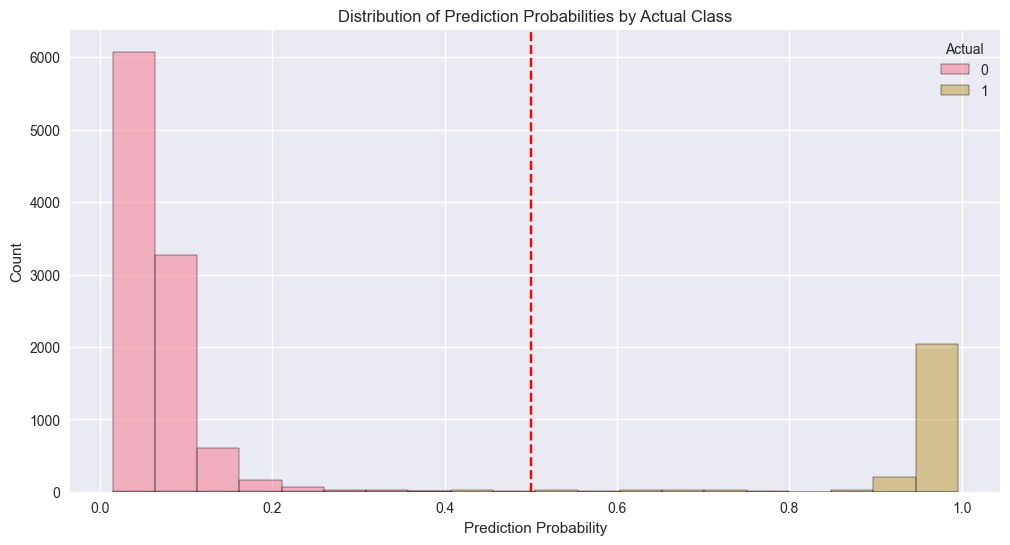

In [ ]:
# Create a DataFrame with test predictions and actual values
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})

# Add original features for analysis
for feature in features:
    test_results[feature] = X_test[feature].values

# Get prediction probabilities
test_probabilities = rf_model.predict_proba(X_test)[:, 1]

# Confidence Analysis
print("\nPrediction Confidence Analysis:")
print("=" * 50)

threshold = 0.2
high_confidence_mask = (test_probabilities < threshold) | (test_probabilities > (1 - threshold))
print(f"\nPredictions with confidence > {threshold*100}%: {sum(high_confidence_mask)}/{len(test_probabilities)} cases")

threshold = 0.4
high_confidence_mask = (test_probabilities < threshold) | (test_probabilities > (1 - threshold))
print(f"\nPredictions with confidence > {threshold*100}%: {sum(high_confidence_mask)}/{len(test_probabilities)} cases")

# Analyze specific cases
print("\nCase Analysis:")
print("="*50)

# Case 1: High confidence correct prediction
high_confidence_correct = test_results[
    ((test_results['Probability'] > 0.8) | (test_results['Probability'] < 0.2)) &
    (test_results['Actual'] == test_results['Predicted'])
].iloc[0]

print("\n1. High Confidence Correct Prediction:")
print(f"   - Actual: {'Default' if high_confidence_correct['Actual'] == 1 else 'Non-Default'}")
print(f"   - Predicted Probability: {high_confidence_correct['Probability']:.2%}")
print("   Key Features:")
for feature in feature_importance.head(3)['feature']:
    print(f"   - {feature}: {high_confidence_correct[feature]:.2f}")

# Case 2: Misclassified case
misclassified = test_results[
    test_results['Actual'] != test_results['Predicted']
].iloc[0]

print("\n2. Misclassified Case:")
print(f"   - Actual: {'Default' if misclassified['Actual'] == 1 else 'Non-Default'}")
print(f"   - Predicted: {'Default' if misclassified['Predicted'] == 1 else 'Non-Default'}")
print(f"   - Probability: {misclassified['Probability']:.2%}")
print("   Key Features:")
for feature in feature_importance.head(3)['feature']:
    print(f"   - {feature}: {misclassified[feature]:.2f}")

# Case 3: Borderline case
borderline = test_results[
    (test_results['Probability'] > 0.45) & (test_results['Probability'] < 0.55)
].iloc[0]

print("\n3. Borderline Case:")
print(f"   - Actual: {'Default' if borderline['Actual'] == 1 else 'Non-Default'}")
print(f"   - Predicted Probability: {borderline['Probability']:.2%}")
print("   Key Features:")
for feature in feature_importance.head(3)['feature']:
    print(f"   - {feature}: {borderline[feature]:.2f}")

# Visualize prediction distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=test_results, x='Probability', hue='Actual', bins=20)
plt.title('Distribution of Prediction Probabilities by Actual Class')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()

## Model Reliability Analysis

 Let's analyze how confident the model is in its predictions.

In [ ]:
# Calculate prediction confidence
confidence_thresholds = [0.2, 0.4, 0.6, 0.8]
for threshold in confidence_thresholds:
    high_confidence_mask = (test_probabilities < threshold) | (test_probabilities > (1 - threshold))
    high_confidence_count = sum(high_confidence_mask)
    print(f"\nPredictions with confidence > {threshold:.0%}: {high_confidence_count}/{len(test_probabilities)} cases")


Predictions with confidence > 20%: 12391/12718 cases

Predictions with confidence > 40%: 12645/12718 cases

Predictions with confidence > 60%: 12718/12718 cases

Predictions with confidence > 80%: 12718/12718 cases


 ## Conclusion and Recommendations

In [ ]:
# Main research findings
print("\n=== Main Research Findings ===")

# 1. Model Effectiveness
print("\n1. Model Effectiveness:")
print(f"- Model Accuracy (ROC-AUC): {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"- Overall Classification Accuracy: {accuracy_score(y_test, y_pred):.1%}")
print(f"- F1-score: {f1_score(y_test, y_pred):.3f}")

# 2. Business Metrics
print("\n2. Business Metrics:")
avg_loan_amount = df_analysis['loan_amnt'].mean()
potential_savings = avg_loan_amount * sum(y_pred == 1)
print(f"- Average Loan Amount: ${avg_loan_amount:,.2f}")
print(f"- Potential Savings from Preventing Defaults: ${potential_savings:,.2f}")
print(f"- Percentage of Risky Loans Identified: {(sum(y_pred == 1) / len(y_pred)):.1%}")

# 3. Important Factors
print("\n3. Key Risk Factors:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
top_features = feature_importance.nlargest(5, 'importance')
for idx, row in top_features.iterrows():
    print(f"- {row['feature']}: {row['importance']:.3f}")

# 4. Practical Recommendations
print("\n4. Practical Recommendations:")
print("- Implement automated scoring system based on the model")
print("- Pay special attention to verifying the most important risk factors")
print("- Regularly update the model based on new data")
print(f"- Set decision threshold at {best_threshold:.2f}")

# 5. Limitations and Next Steps
print("\n5. Limitations and Next Steps:")
print("- Regular model updates are necessary")
print("- Consider potential changes in economic conditions")
print("- Consider including additional risk factors")
print("- Conduct pilot implementation of the system")

# Save results
results = {
    'model_metrics': {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    },
    'business_metrics': {
        'avg_loan_amount': float(avg_loan_amount),
        'potential_savings': float(potential_savings),
        'risk_loan_percentage': float(sum(y_pred == 1) / len(y_pred))
    },
    'top_features': top_features.to_dict('records')
}

# Save results to JSON
with open('model_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults saved to 'model_results.json'")


=== Main Research Findings ===

1. Model Effectiveness:
- Model Accuracy (ROC-AUC): 0.997
- Overall Classification Accuracy: 99.0%
- F1-score: 0.975

2. Business Metrics:
- Average Loan Amount: $68.48
- Potential Savings from Preventing Defaults: $162,492.28
- Percentage of Risky Loans Identified: 18.7%

3. Key Risk Factors:
- loan_cost: 0.317
- utilization_rate: 0.298
- payment_efficiency: 0.271
- total_pymnt: 0.044
- int_rate: 0.013

4. Practical Recommendations:
- Implement automated scoring system based on the model
- Pay special attention to verifying the most important risk factors
- Regularly update the model based on new data
- Set decision threshold at 0.26

5. Limitations and Next Steps:
- Regular model updates are necessary
- Consider potential changes in economic conditions
- Consider including additional risk factors
- Conduct pilot implementation of the system

Results saved to 'model_results.json'
- loan_cost: 0.317
- utilization_rate: 0.298
- payment_efficiency: 0.271


P.S.
It was a greate journey =)
Thank you!